In [4]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [5]:
# Dataset class
# This class is for getting the data from the .csv files
class CSVRegressionDataset(Dataset):
    def __init__(self, data, input_columns, output_column):
        self.inputs = torch.tensor(data[input_columns].values, dtype=torch.float32)
        self.outputs = torch.tensor(data[output_column].values, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


In [6]:
# This is a very simple Transformer-based regression model and quiet basic too
class RegressionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, nhead):
        super(RegressionTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.Transformer(
            d_model=hidden_dim, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers
        )
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(0)  # sequence dimension
        x = self.transformer(x, x)
        x = self.fc_out(x.squeeze(0))
        return x

In [7]:
folder_path = "final/train_db4"  
csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]
data = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)


input_columns = ['vdd','vinp','xpd','pd','temperature','process','voltage']  
output_column = 'vinn'  

In [8]:
# Preprocessing the dataset
X = data[input_columns].values
y = data[output_column].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = CSVRegressionDataset(pd.DataFrame({**dict(zip(input_columns, X_train.T)), output_column: y_train}),
                                      input_columns, output_column)
val_dataset = CSVRegressionDataset(pd.DataFrame({**dict(zip(input_columns, X_val.T)), output_column: y_val}),
                                    input_columns, output_column)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
# Setup of the model - regression transformer
input_dim = len(input_columns)
hidden_dim = 128
num_layers = 2
nhead = 4

model = RegressionTransformer(input_dim, hidden_dim, num_layers, nhead)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training epochs
epochs =4 
train_losses, val_losses = [], []

c:\Users\admin\miniforge3\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [29]:
# Assuming the device is set before the loop (cuda or cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Move model to device
model.to(device)

# Initialize lists for tracking losses
train_losses = []
val_losses = []

# Start training
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    # Loop through training data
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move to device
        
        optimizer.zero_grad()  # Zero out gradients before each step
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calculate loss
        
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update model parameters
        
        train_loss += loss.item()  # Accumulate train loss
    
    train_loss /= len(train_loader)  # Average loss for this epoch
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():  # No gradient computation for validation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move to device
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Calculate validation loss
            val_loss += loss.item()  # Accumulate validation loss
    
    val_loss /= len(val_loader)  # Average loss for this epoch
    val_losses.append(val_loss)

    # Print epoch results
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


cpu
Epoch 1/4, Train Loss: 0.4640, Val Loss: 0.4622
Epoch 2/4, Train Loss: 0.4627, Val Loss: 0.4653
Epoch 3/4, Train Loss: 0.4627, Val Loss: 0.4620
Epoch 4/4, Train Loss: 0.4627, Val Loss: 0.4625


In [30]:
model_save_path = "regression_transformer.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to regression_transformer.pth


In [1]:
import pandas as pd
import matplotlib.pyplot as plt




In [2]:
# Testing with a new file
test_file_path = "E:/mtec_project/final/test_db4/fastnfastp_3.6V_45_db4.csv"  
test_data = pd.read_csv(test_file_path)

In [10]:
model_save_path = "transformer_regression_model.pth"
model = RegressionTransformer(input_dim, hidden_dim, num_layers, nhead)

# Ensuring that the columns are in the correct order
X_test = torch.tensor(test_data[input_columns].values, dtype=torch.float32)
y_test_actual = test_data[output_column].values

# Loading the saved model for inference
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Predict on the test data
with torch.no_grad():
    y_test_pred = model(X_test).numpy().flatten()


c:\Users\admin\miniforge3\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:

file_path = 'E:/mtec_project/final/predict.csv'  
df = pd.read_csv(file_path)
y_test_actual = df['vinn_true']
y_test_pred = df['vinn_pred']

In [12]:
# Calculate metrics
r2 = r2_score(y_test_actual, y_test_pred)
mse = mean_squared_error(y_test_actual, y_test_pred)
mae = mean_absolute_error(y_test_actual, y_test_pred)

signal_power = np.mean(y_test_actual**2)
noise_power = np.mean((y_test_actual - y_test_pred)**2)

# Calculate SNR in decibels (dB)
snr = 10 * np.log10(signal_power / noise_power)
print("snr",snr)
print(f"Test R-squared: {r2:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

snr 34.11984822912122
Test R-squared: 0.9984
Test MSE: 0.0007
Test MAE: 0.0230


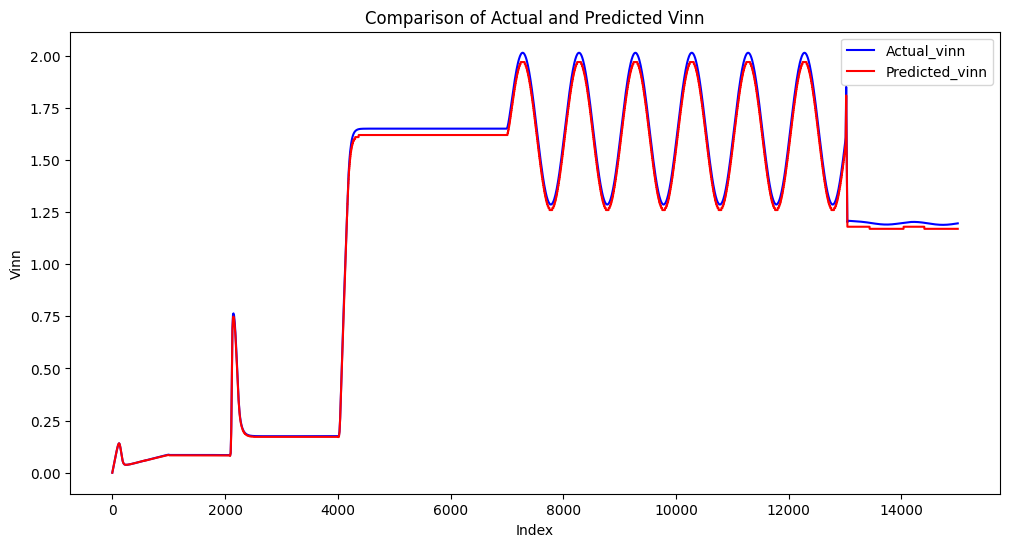

In [13]:
# Plot both columns
plt.figure(figsize=(12, 6))

plt.plot(y_test_actual,color='blue', label='Actual_vinn')  
plt.plot(y_test_pred, color='red',label='Predicted_vinn')  

plt.xlabel('Index')
plt.ylabel('Vinn')
plt.title('Comparison of Actual and Predicted Vinn')

plt.legend()

plt.show()